In [135]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [136]:
class scaledDotProduct(nn.Module):
    '''
        Attention(Q, K, V ) = softmax( QK^T/√d_k)V 
    
    '''
    #Takes number of embedded, head_size, context length
    def __init__(self, embn, hdim, con_l, drop=0.0):

        super(scaledDotProduct, self).__init__()
        #dim is (d_k) when sqrt'd it is meant to counter small gradients in large sets of queries and keys
        self.k = nn.Linear(embn, hdim, bias=False)
        self.q = nn.Linear(embn, hdim, bias=False)
        self.v = nn.Linear(embn, hdim, bias=False)
        self.d_k = np.sqrt(hdim)

        self.register_buffer('mask', torch.tril(torch.ones(con_l,con_l)))
        #Simple drop out 
        self.drop = nn.Dropout(drop)

    def forward(self, x, ret_att=False):
        #first two dimensions are batch and number of heads?
        B,T,C = x.shape
        k = self.k(x)
        q = self.q(x)

        n = torch.matmul(q, k.transpose(-2,-1)) / k.shape[-1]**-0.5
        n = n.masked_fill_(self.mask[:T,:T]==0, -1e9)
        #Drop out referenced later in paper but not in original diagram
        att = self.drop(F.softmax(n, dim=-1))

        v = self.v(x)

        out = torch.matmul(n, v)
        if ret_att:
            return out, att 
        return out
        
        


In [137]:
#Scaled dot product attention testing
#dim should be size of q and k
scaled_dot = scaledDotProduct(10,1,2)
q = torch.rand(1,2,10)
k = torch.rand(1,2,10)
v = torch.rand(1,2,10)


scaled_dot(v)

tensor([[[-7.1649e+08],
         [-1.4003e-01]]], grad_fn=<UnsafeViewBackward0>)

In [138]:
class multiHeadedAttention(nn.Module):
    def __init__(self, n_heads, dims, embn, con_l, dropout=0.0):
        super(multiHeadedAttention, self).__init__()
        #d_k=d_v = dims/h

        self.n_heads = n_heads

        self.attn = nn.ModuleList([scaledDotProduct(embn, dims, con_l) for _ in range(n_heads)])
        #Final linear layer after concat and attention
        self.fc = nn.Linear(n_heads*dims, embn)

        self.drop = nn.Dropout(dropout)
        

    def forward(self, x):
        out = torch.cat([h(x) for h in self.attn], dim=-1)
        out = self.drop(self.fc(out))
        return out

        


In [139]:
#heads, d_model, d_km d_v as per the paper
multiHead = multiHeadedAttention(6, 512, 64, 512)
#batches, dims, dimensionalityxn_heads

v = torch.rand(1,512,64)


multiHead(v)

tensor([[[ 2.0292e+11, -5.1790e+10, -8.2098e+10,  ..., -4.3398e+10,
           1.2494e+10, -4.4693e+10],
         [ 2.0248e+11, -5.1858e+10, -8.1828e+10,  ..., -4.3250e+10,
           1.2541e+10, -4.4495e+10],
         [ 2.0205e+11, -5.1739e+10, -8.1611e+10,  ..., -4.3135e+10,
           1.2644e+10, -4.4498e+10],
         ...,
         [ 8.9505e+08, -2.2274e+08, -4.0160e+08,  ..., -2.1368e+08,
          -1.3840e+08, -2.0218e+08],
         [ 4.5334e+08, -1.8520e+08, -2.4330e+08,  ..., -2.1392e+08,
          -9.7377e+07, -2.1980e+07],
         [ 1.9105e+02,  2.6788e+03,  1.4428e+03,  ..., -1.4861e+03,
           2.0806e+03,  1.7174e+03]]], grad_fn=<ViewBackward0>)

In [140]:
class positionFeedFoward(nn.Module):
    def __init__(self, inp, hid, drop=0.0):
        super(positionFeedFoward, self).__init__()
        self.w1 = nn.Linear(inp,hid)
        self.w2 = nn.Linear(hid,inp)
        self.norm = nn.LayerNorm(inp, eps=1e-6)
        self.drop = nn.Dropout(drop)

    def forward(self, x):

        x = self.w2(F.relu(self.w1(x)))
        x = self.drop(x)

        return x

In [141]:
class Decoder(nn.Module):
    '''Combinds MultiHeadedAttention and FeeForward, three layers'''
    def __init__(self, dims, nheads, embn, con_l, drop=0.0):
        super(Decoder, self).__init__()
        
        self.slf_attn = multiHeadedAttention(nheads, dims,embn, con_l, dropout=drop)
        
        self.ffn = positionFeedFoward(embn, embn, drop=drop)

        self.norm1 = nn.LayerNorm(embn)
        self.norm2 = nn.LayerNorm(embn)

    def forward(self, x):
        x = x + self.slf_attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))

        return x

In [142]:
#heads, d_model, d_km d_v as per the paper
enc = Decoder(512, 8, 64, 512)
#batches, dims, dimensionalityxn_heads
q = torch.rand(1,512,64)
k = torch.rand(1,512,64)
v = torch.rand(1,512,64)


enc(v)

tensor([[[ 1.2863e+09, -1.1753e+09, -1.0655e+10,  ..., -3.0022e+09,
          -9.6994e+08, -4.8295e+09],
         [ 9.9893e+08, -1.3135e+09, -1.0782e+10,  ..., -2.7838e+09,
          -1.4330e+09, -4.9604e+09],
         [ 6.3394e+08, -1.2942e+09, -1.0552e+10,  ..., -2.8635e+09,
          -1.5451e+09, -5.0875e+09],
         ...,
         [-4.5630e+08,  1.1973e+08, -3.2257e+08,  ..., -7.4419e+08,
          -3.7699e+08,  4.3763e+08],
         [-2.5703e+08, -6.9761e+07, -1.0041e+08,  ..., -5.2366e+08,
          -3.6616e+08,  9.9175e+07],
         [ 9.8513e+02,  6.4013e+03, -2.6455e+03,  ...,  6.6006e+03,
          -1.1466e+03, -2.5055e+03]]], grad_fn=<AddBackward0>)

In [143]:
#Pytoch version adapted from here https://pub.aimind.so/creating-sinusoidal-positional-embedding-from-scratch-in-pytorch-98c49e153d6
class PosEncoding(nn.Module):
    def __init__(self, hid, n_pos=200):
        super(PosEncoding, self).__init__()

        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_pos, hid))

    def _get_sinusoid_encoding_table(self, n_pos, hid):

        if hid %2 != 0:
            raise ValueError("Sinusoidal positional embedding cannot apply to odd token embedding dim={}".format(hid))
        
        positions = torch.arange(0,n_pos).unsqueeze_(1)
        embeds = torch.zeros(n_pos, hid)

        denom = torch.pow(10000, 2 * torch.arange(0, hid//2)/2)
        embeds[:, 0::2] = torch.sin(positions/denom)
        embeds[:, 1::2] = torch.cos(positions/denom)
        embeds = embeds.unsqueeze(0)

        return embeds
    
    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()




In [144]:
class languageModel(nn.Module):
    '''Decoder model'''
    def __init__(
            self, n_vocab, embn, n_layers, n_head, dims, dropout=0.2 , con_l=200
    ):
        super(languageModel, self).__init__()

        self.word_emb = nn.Embedding(n_vocab, embn)
        self.pos_enc = nn.Embedding(con_l, embn)
        self.stack = nn.Sequential(
            *[Decoder(dims, n_head, embn, con_l, drop=dropout) for _ in range(n_layers)]
        )
       
        self.layer_norm = nn.LayerNorm(embn)
        self.fc = nn.Linear(embn, n_vocab)

    def forward(self, x, tar=None):
        #batch, time
        B, T = x.shape

        tok = self.word_emb(x)
        pos = self.pos_enc(torch.arange(T, device=device))
        x = tok + pos
        x = self.stack(x)
        x = self.layer_norm(x)
        logits = self.fc(x)

        if tar is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            tar = tar.view(B*T)
            loss = F.cross_entropy(logits, tar)

        return logits, loss


In [145]:
#Text file containing english sentences
file_path = './raw_sentences.txt'

sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

vocab = set([w for s in sentences for w in s])

print(len(sentences)) # 97162
print(len(vocab))

97162
250


In [146]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

for i in range(10):
    print(train[i])

['last', 'night', ',', 'he', 'said', ',', 'did', 'it', 'for', 'me', '.']
['on', 'what', 'can', 'i', 'do', '?']
['now', 'where', 'does', 'it', 'go', '?']
['what', 'did', 'the', 'court', 'do', '?']
['but', 'at', 'the', 'same', 'time', ',', 'we', 'have', 'a', 'long', 'way', 'to', 'go', '.']
['that', 'was', 'the', 'only', 'way', '.']
['this', 'team', 'will', 'be', 'back', '.']
['so', 'that', 'is', 'what', 'i', 'do', '.']
['we', 'have', 'a', 'right', 'to', 'know', '.']
['now', 'they', 'are', 'three', '.']


In [147]:
count = Counter()
n=0
sum = 0
for n in range(len(sentences)):
    sum+=len(sentences[n])
    count.update(sentences[n])
print('avg: ' + str(sum/n))
print('unique: '+str(len(count)))
print('10 most common: ')
keys = sorted(count, key=count.get, reverse=True)[:10]
print(keys)
print("total words: ")
sum = 0
for val in list(count.values()):
    sum+=val
print(sum)
count_percent ={}
for key, val in list(count.items()):
    count_percent[key]=round((val/sum)*100,2)


print("Percentages")
print(count_percent)

avg: 7.792962196766192
unique: 250
10 most common: 
['.', 'it', ',', 'i', 'do', 'to', 'nt', '?', 'the', 'that']
total words: 
757172
Percentages
{'no': 0.46, ',': 3.25, 'he': 2.03, 'says': 0.13, 'now': 0.58, '.': 10.69, 'and': 1.22, 'what': 1.51, 'did': 1.12, 'do': 2.67, '?': 2.14, 'the': 2.11, 'money': 0.29, "'s": 2.08, 'there': 0.95, 'that': 2.09, 'was': 1.14, 'less': 0.04, 'than': 0.08, 'a': 0.94, 'year': 0.24, 'ago': 0.05, 'but': 1.26, 'made': 0.11, 'only': 0.18, 'first': 0.16, 'still': 0.22, 'time': 0.59, 'for': 0.68, 'them': 0.42, 'to': 2.58, 'it': 3.86, 'should': 0.26, 'nt': 2.17, 'have': 1.08, 'they': 1.41, 'come': 0.37, 'down': 0.1, 'people': 0.48, 'i': 2.94, 'know': 1.15, 'where': 0.34, 'is': 1.64, 'would': 0.47, 'who': 0.27, 'will': 0.48, 'be': 0.86, 'not': 1.3, 'one': 0.57, 'you': 1.69, 'could': 0.39, 'are': 1.08, 'place': 0.16, 'like': 0.6, 'of': 0.78, 'here': 0.44, 'so': 0.54, 'on': 0.35, 'or': 0.19, 'him': 0.26, 'both': 0.06, 'going': 0.6, 'get': 0.54, 'in': 0.61, 'my': 

In [148]:
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                  ['other', 'one', 'since', 'yesterday'],
                                  ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    sent_inds=[]
    for sent in sents:
        sent_ind = []
        for word in sent:
            sent_ind.append(vocab_stoi[word])
        sent_inds.append(sent_ind)
    return sent_inds

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    fourgrams =[]
    for seq in seqs:
        while len(seq)>3:
            fourgrams.append(seq[:4])
            seq=seq[1:]
    return fourgrams

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

print(generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]))
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

[[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]


In [149]:
train4grams[0]

array([206, 105, 186, 108])

In [150]:
model = languageModel(
    len(vocab),  384 ,6, 6, 3
    ).to(device)



In [151]:
test_inp = torch.tensor(train4grams[:2]).to(device)
out = model(test_inp[:,:3])
print(out)
print(out[0].shape)

(tensor([[[ 0.6950,  0.9191, -0.0025,  ...,  0.1541, -0.8267, -0.8748],
         [ 0.1041, -1.0993,  0.1905,  ..., -0.0933, -0.1650,  0.4509],
         [-0.5110, -0.5531, -0.6218,  ...,  0.6447,  0.3055, -0.5859]],

        [[-0.0846, -0.1543,  0.2943,  ..., -0.6288, -0.1957,  0.2814],
         [-0.2721, -0.4361,  0.0980,  ..., -0.0467,  0.1455,  0.5094],
         [ 0.2692, -0.2490, -1.4512,  ...,  0.4248, -0.6574,  0.0394]]],
       device='cuda:0', grad_fn=<ViewBackward0>), None)
torch.Size([2, 3, 250])


In [152]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xs, ts = data[i:i+batch_size,:3], data[i:i+batch_size,3]
        
        # forward pass prediction
        z = model(torch.Tensor(xs).long().to(device))[0]
        z = z.cpu().detach().numpy()[:,0,:] # convert the PyTorch tensor => numpy array
        pred = np.argmax(z, axis=-1)
        correct += np.sum(pred == ts)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

In [153]:
def train(model, train_data=train4grams, validation_data = valid4grams, batch_size=64, lr=3e-4, weight_decay=0, max_iters=2500, checkpoint_path=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98))

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0

    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break
            xs, ts, trg = train_data[i:i+batch_size,:3], train_data[i:i+batch_size,3], train_data[i:i+batch_size, 2:]

            # convert from numpy arrays to PyTorch tensors
            xs = torch.Tensor(xs).long().to(device)
            ts = torch.Tensor(ts).long().to(device)
            trg = torch.Tensor(trg).long().to(device)

            zs = model(xs)[0][:,0,:]
            loss = criterion(zs, ts) # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch

            #for param_group in optimizer.param_groups:
                #param_group['lr'] = 250**(-0.5) * min(n**(-0.5), n * 4000**(-1.5))

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.cpu().detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs



In [154]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 5.690816]
Iter 500. [Val Acc 27%] [Train Acc 27%, Loss 3.594321]
Iter 1000. [Val Acc 28%] [Train Acc 29%, Loss 3.066849]
Iter 1500. [Val Acc 29%] [Train Acc 30%, Loss 2.740506]
Iter 2000. [Val Acc 29%] [Train Acc 30%, Loss 3.300745]
Iter 2500. [Val Acc 30%] [Train Acc 31%, Loss 2.817350]
Iter 3000. [Val Acc 30%] [Train Acc 31%, Loss 2.936415]
Iter 3500. [Val Acc 30%] [Train Acc 31%, Loss 2.462865]
Iter 4000. [Val Acc 31%] [Train Acc 32%, Loss 3.094291]
Iter 4500. [Val Acc 31%] [Train Acc 32%, Loss 2.309845]
Iter 5000. [Val Acc 31%] [Train Acc 32%, Loss 2.515813]
Iter 5500. [Val Acc 32%] [Train Acc 32%, Loss 2.722587]
Iter 6000. [Val Acc 32%] [Train Acc 33%, Loss 2.972736]
Iter 6500. [Val Acc 32%] [Train Acc 33%, Loss 3.507863]
Iter 7000. [Val Acc 32%] [Train Acc 33%, Loss 3.164027]
Iter 7500. [Val Acc 32%] [Train Acc 33%, Loss 2.509786]
Iter 8000. [Val Acc 32%] [Train Acc 33%, Loss 3.211050]


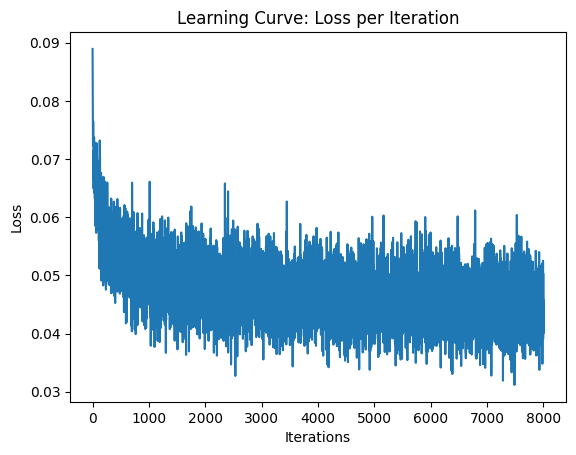

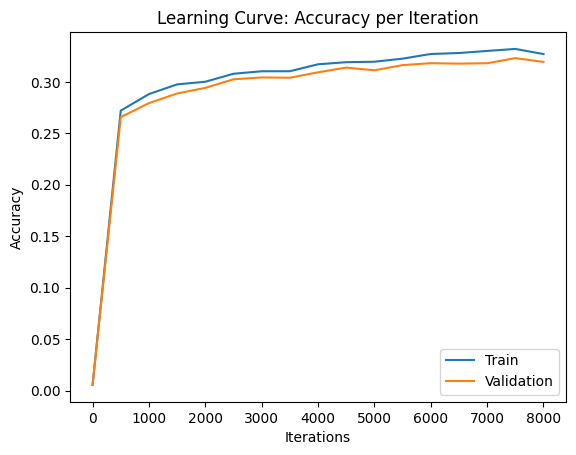

In [155]:
train_info = train(model, max_iters=8000)
plot_learning_curve(*train_info)

In [28]:

testinp = test4grams[5]
test_words = []
for ind in testinp:
    test_words.append(vocab_itos[ind])
print(testinp)
inp=torch.tensor(testinp[:3]).to(device).unsqueeze(0)

print(inp)

print(inp.shape)

modelout = model(inp)[0]
print(modelout)
pred = torch.argmax(modelout, dim=-1)
print(pred)
pred_words = []
for ind in pred.cpu().detach().numpy()[0]:
    pred_words.append(vocab_itos[ind])
print(test_words)
print(pred_words)

[ 22 108 116  28]
tensor([[ 22, 108, 116]], device='cuda:0')
torch.Size([1, 3])
tensor([[[-1.5279e+00, -7.4358e-01,  4.9686e-01, -1.8415e+00, -4.7629e-01,
           5.2956e-01, -2.0412e+00,  8.4338e-01, -2.3508e+00, -3.8674e+00,
          -3.6880e+00, -5.4001e+00, -2.2114e+00, -1.2078e+00, -4.0878e+00,
          -3.4364e+00,  1.0442e+00, -4.8098e+00, -3.0519e+00,  3.5112e+00,
          -4.1399e+00,  2.4353e+00, -1.9684e+00, -1.1832e+00, -3.0036e+00,
           2.2936e-01,  2.5131e+00, -3.5668e+00,  5.5182e+00,  1.3119e-02,
          -3.8225e+00, -1.5274e+00, -5.6744e-01, -3.2315e+00, -6.7556e+00,
          -2.6649e+00, -2.8101e+00, -1.2313e+00, -8.2843e-01, -1.0800e+00,
           1.9157e+00, -6.2089e+00,  1.4816e+00, -1.5231e+00, -2.3198e+00,
          -2.3327e+00,  2.5658e-01, -4.5430e-01, -1.3397e+00, -3.3498e+00,
          -1.3301e+00, -3.0761e+00,  2.3246e+00,  9.4884e-01, -1.1302e+00,
          -2.1818e+00, -5.0656e-01, -2.7348e+00,  3.1470e+00, -1.4474e+00,
          -1.0267e+0

In [158]:
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 50 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)[0]
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = Y.view(B*T)
            loss = F.cross_entropy(logits, targets)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [161]:
model = languageModel(len(vocab),  384,6, 6, 50
    )
m = model.to(device)
# print the number of parameters in the model
#print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print(next(m.parameters()).is_cuda)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits = model(xb)[0]
    loss = F.cross_entropy(logits, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

True
step 0: train loss 5.4609, val loss 5.4656


RuntimeError: Expected target size [64, 250], got [64, 50]